## Covid-19 county based map plots

* https://github.com/nytimes/covid-19-data)

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
sns.set_context('talk')
import panel as pn
import panel.widgets as pnw
pn.extension()
import geopandas as gpd
import json
import datetime as dt

/usr/local/lib/python3.9/dist-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
pop = pd.read_csv('co-est2020.csv')
pop['county'] = pop.CTYNAME.apply(lambda x: ' '.join(x.split()[:-1]))
pop

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2020,county
0,40,3,6,1,0,Alabama,Alabama,4921532,
1,50,3,6,1,1,Alabama,Autauga County,56145,Autauga
2,50,3,6,1,3,Alabama,Baldwin County,229287,Baldwin
3,50,3,6,1,5,Alabama,Barbour County,24589,Barbour
4,50,3,6,1,7,Alabama,Bibb County,22136,Bibb
...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,42673,Sweetwater
3190,50,4,8,56,39,Wyoming,Teton County,23497,Teton
3191,50,4,8,56,41,Wyoming,Uinta County,20215,Uinta
3192,50,4,8,56,43,Wyoming,Washakie County,7760,Washakie


In [6]:
df = pd.read_csv('us-counties.csv')
df['date'] = pd.to_datetime(df.date)

df=df.sort_values('date')
df['daily'] = df.groupby(['state','county'])['cases'].diff().fillna(0)
df['daily'] = df.daily.clip(lower=0)
#df['daily'] = df.groupby(['state','county'])['daily'].transform(lambda x: x.rolling(24).mean()).fillna(0)
print (len(df))
#print (df[:4])
df = df.merge(pop,left_on=['county','state'],right_on=['county','STNAME'],how='left')
df['drate'] = (df.daily/df.POPESTIMATE2020)*1000
print (len(df))
#print (df[:4])
gdf = gpd.read_file('map_data/cb_2018_us_county_5m.shp')

1904345
1907966


In [53]:
sdf = df.set_index('date').groupby('county').resample("W")[['cases','deaths','daily','drate']].mean().reset_index()
sdf['month'] = sdf.date.dt.month
sdf['year'] = sdf.date.dt.year
sdf['week'] = sdf.date.dt.weekofyear
sdf[:5]

<ipython-input-53-5dffb08d7123>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  sdf['week'] = sdf.date.dt.weekofyear


,county,date,cases,deaths,daily,drate,month,year,week
0,Abbeville,2020-03-22,1.000000,0.0,0.000000,0.000000,3,2020,12
1,Abbeville,2020-03-29,3.000000,0.0,0.428571,0.017562,3,2020,13
2,Abbeville,2020-04-05,5.000000,0.0,0.428571,0.017562,4,2020,14
3,Abbeville,2020-04-12,7.000000,0.0,0.571429,0.023415,4,2020,15
4,Abbeville,2020-04-19,11.428571,0.0,1.142857,0.046831,4,2020,16


<AxesSubplot:xlabel='date'>

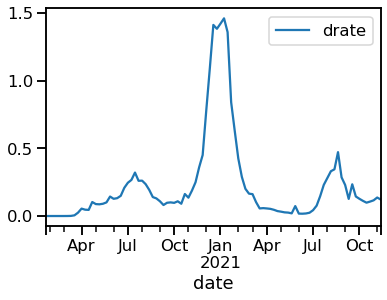

In [54]:
x = sdf[sdf.county=='Los Angeles']
#print (x)
x.plot(x='date',y='drate')

In [ ]:
print (df[:3])
print (gdf[:4])

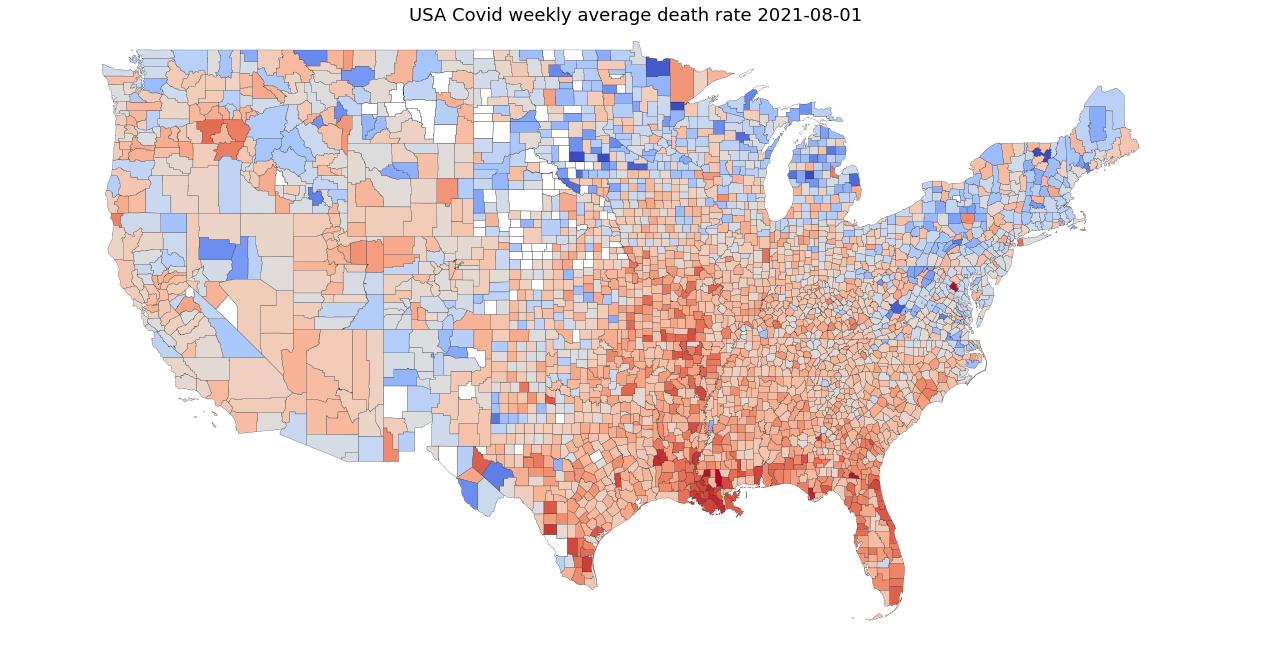

In [87]:
def plot_map(x, fig, label=None):
    """Plot map """
    plt.clf()    
    ax=fig.add_subplot(label='a')
    import matplotlib
    norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=x.drate.max())
    x.plot(column='drate',cmap='coolwarm',lw=.2,ec='black',ax=ax,norm=norm)
    ax.set_xlim([-130,-60])
    ax.set_ylim(23,50)
    ax.set_title(label)
    ax.axis('off')
    return

date='2021-08-01'
sub = sdf[sdf.date==date].dropna()
#sub['drate'] = sub.drate.clip(upper=2)
#print (len(sub))
x = gdf.merge(sub,left_on='NAME',right_on='county',how='right')
#print (sub.sort_values('dday',ascending=False)[:5])
fig=plt.figure(figsize=(18,10))
#fig,ax=plt.subplots(figsize=(18,10))
plot_map(x, fig, date)
plt.tight_layout()
fig.savefig('us_counties_%s.jpg' %date)

In [ ]:
fig=plt.figure(figsize=(18,10))
map_pane.object = fig
import time
for date in sdf.date.unique():
    #print (date)
    sub = sdf[sdf.date==date].dropna()
    #sub['drate'] = sub.drate.clip(upper=2)
    x = gdf.merge(sub,left_on='NAME',right_on='county',how='right')
    label=str(date)[:10]
    plot_map(x, fig, label)    
    fig.savefig('tmp/%s.png' %label)
    #map_pane.object=fig
    #map_pane.param.trigger('object')
    time.sleep(.1)
plt.clf();

In [ ]:
map_pane = pn.pane.Matplotlib(width=1000)
map_pane

In [ ]:
#make movie
cmd = 'cat tmp/*.png | ffmpeg -framerate 1 -f image2pipe -i - -c:v libx264 -r 30 -pix_fmt yuv420p output.mp4'

In [ ]:
def dashboard():  
    
    #fig = plt.Figure(figsize=(14,6))
    fig,ax=plt.subplots(figsize=(14,10))
    map_pane=pn.pane.Matplotlib(width=1000)
    map_pane.object = fig
    date_picker = pnw.DatePicker(name='Pick Date',width=200)
    from datetime import date  
    date_picker.value=date(2020, 1, 1)
    date_slider = pnw.DateSlider(name='Date', start=dt.datetime(2020, 1, 1), 
                                 end=dt.datetime(2021, 10, 31), value=dt.datetime(2021, 1, 1))
    

    def update_map(event=None, date=None):        
        date = str(date_slider.value)
        sub = df[df.date==date]
        x = gdf.merge(sub,left_on='NAME',right_on='county',how='right')        
        plot_map(x,fig) 
        map_pane.param.trigger('object')    
        return
    
    sdate='2021-02-02'
    sub = df[df.date==sdate]
    x = gdf.merge(sub,left_on='NAME',right_on='county',how='right')    
    plot_map(x,fig) 
    date_slider.param.watch(update_map,'value')
    
    dashboard = pn.Column(date_slider,pn.Row(pn.Column(date_picker),map_pane))
    return dashboard

app=dashboard()


Column
    [0] DateSlider(end=datetime.datetime(2021, ..., name='Date', start=datetime.datetime(2020, ..., value=datetime.datetime(2021, ...)
    [1] Row
        [0] Column
            [0] DatePicker(name='Pick Date', value=datetime.date(2020, 1, 1), width=200)
        [1] Matplotlib(Figure, width=1000)
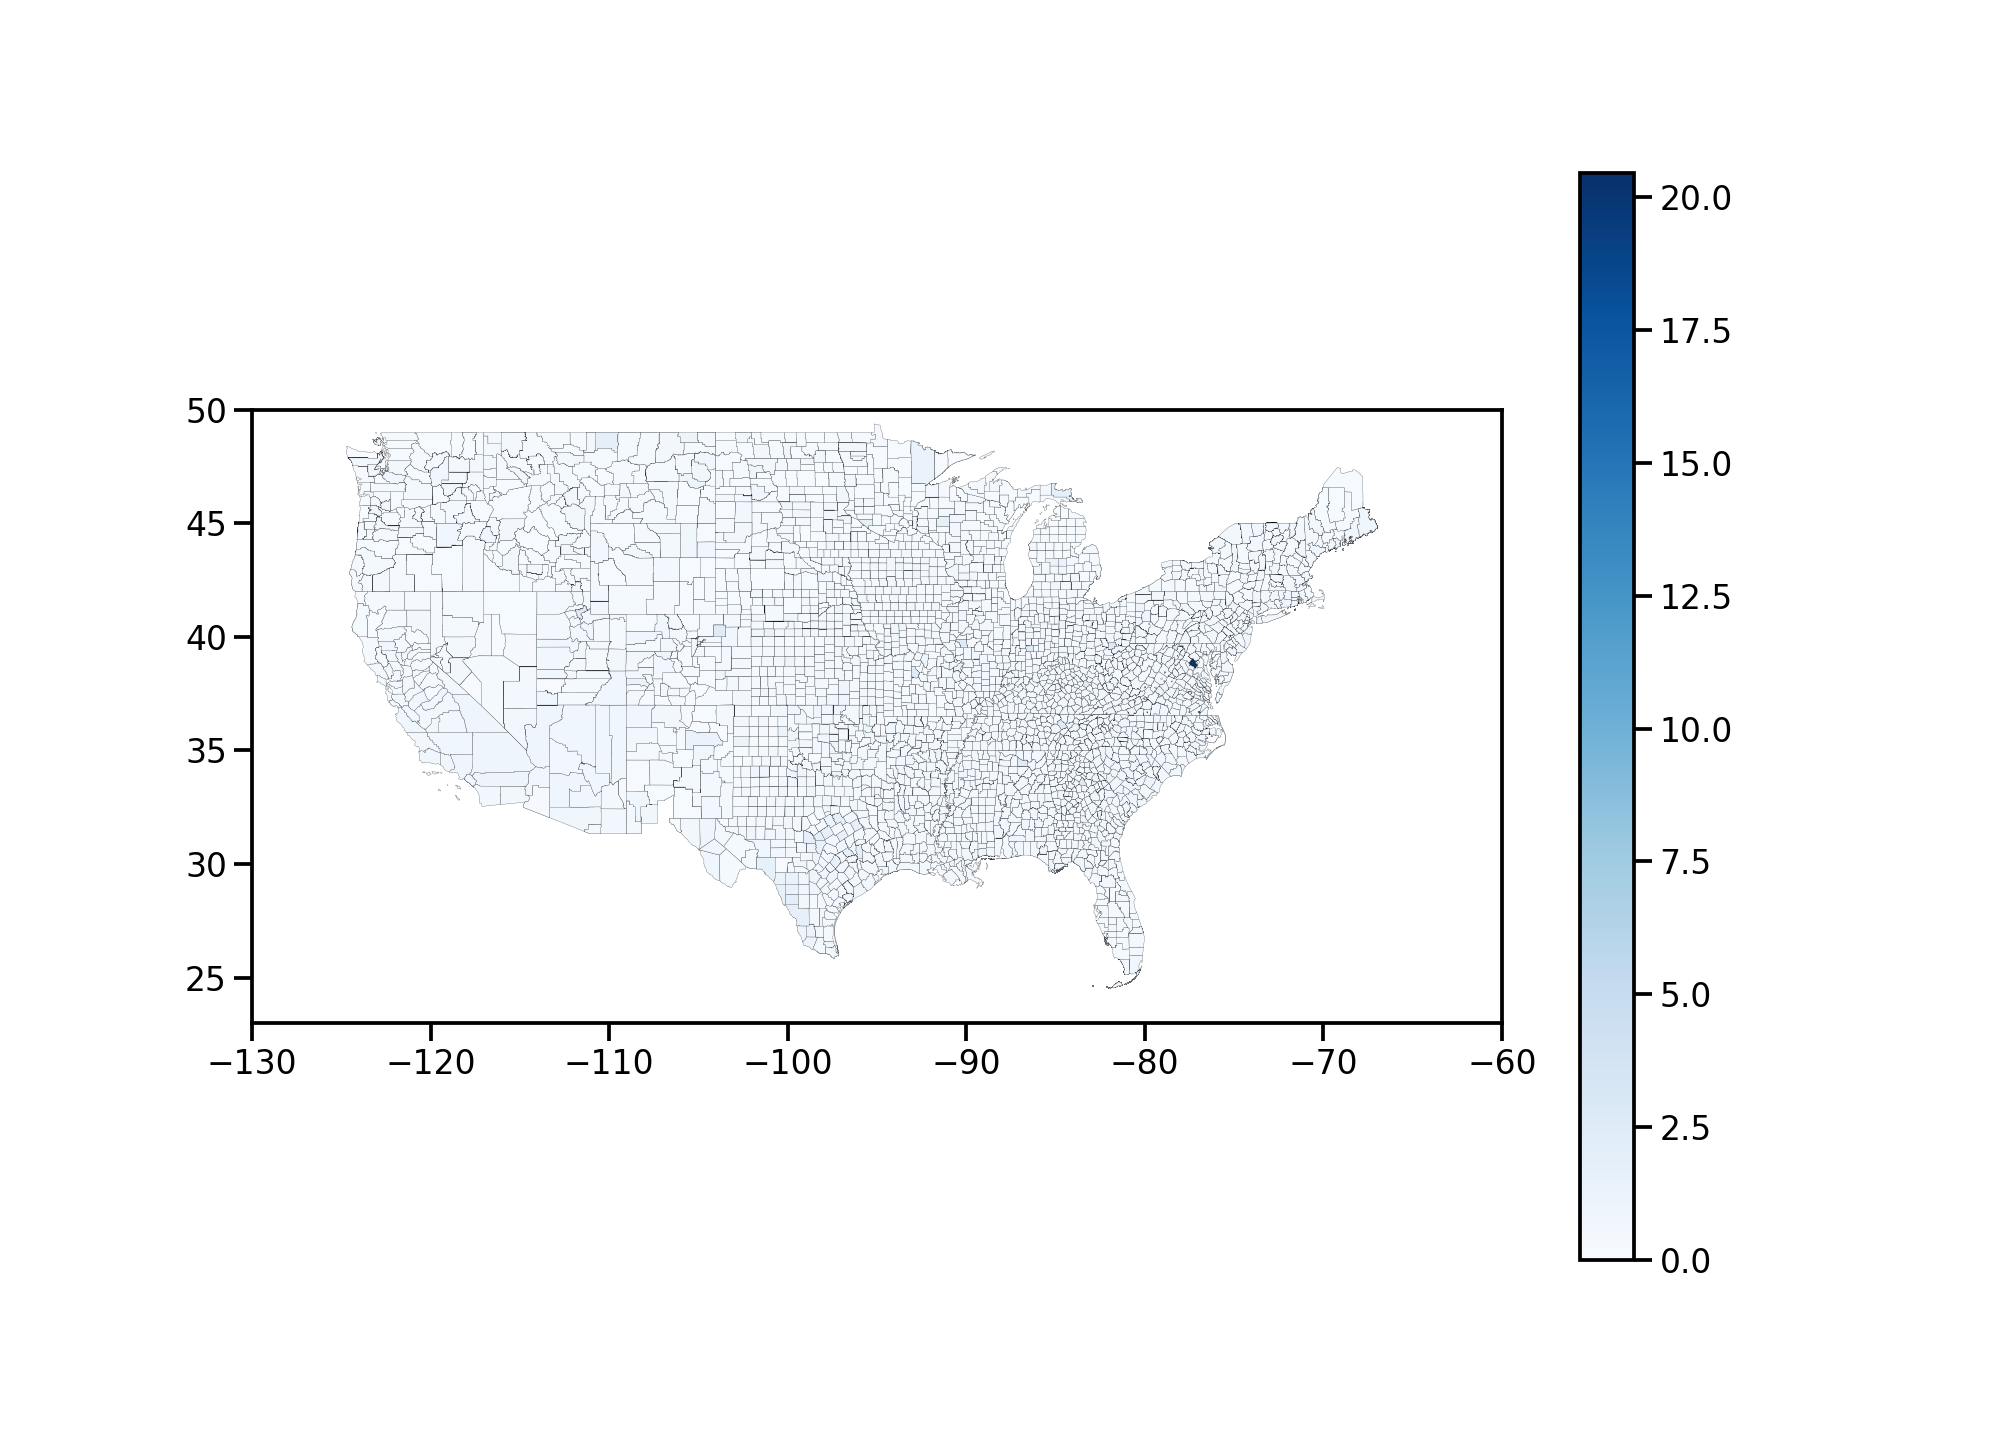

In [473]:
app